# LSTM
Author: Michal Stary

This notebook contains language modelling inspired Spectral models of m/z spectra coming from Gas-Chromatography Mass Spectrometry (GC-MS) measurements.

We build up on the Spec2Vec paper that applied the Word2Vec model on the LC-MS/MS measurements.

One aim is to evaluate the quality of peak embeddings obtained by Spec2Vec on the GC-MS measuremtnes. 

Next we are using the language modelling technique to model the m/z spectra. Our current plans are oriented towards the use of transformers, still simpler models seem to be necessary to empirically understand the domain. Therefore we are also presenting:

* simple KNN based on Spec2Vec (based on summed sure peaks)
* simple KNN based on Spec2Vec (based on individual sure peaks)
* Sent2Vec like add-on to Word2Vec 
* Pure LSTM on onehotted peaks 
* LSTM build on top of freezed Spec2Vec embeddings
* LSTM build on top of Spec2Vec embeddings
* LSTM build on top of random embeddings
* Pure LSTM on onehotted peaks with added intensity feature
* LSTM build on top of freezed Spec2Vec embeddings with added intensity feature
* LSTM build on top of Spec2Vec embeddings with added intensity feature
* LSTM build on top of random embeddings with added intensity feature
* Transormer Decoder with intensity order as positional encoding

In this notebook, the possbile training objective is the causal language modelling ("language generation") style. Also the "given k, predict \[k+1th, random, all\] is supported though not reccomended. 

TODO - add multilabel prediction training objective
TODO - add distribution prediction training objective

Note that all the training was done on one A100 GPU (but T4 is enough, just lower the batch size). Due to small dataset size (~15k spectra in train set), the training times are rather low:  2-5min/model for the k+1th task; 10-25 min/model for generating task. Whole notebook (without spec2vec training) takes few hours at maximum.

Due to the future availibity of 300k spectral dataset (NIST) that is recording the m/z values at integer-like precision, we have used this integer precision too. And as experiments with MONA shown, even this dataset is having a negligible amount of peaks on higher precision. Therefore, the integer precision seems to be the only reasonable one.

Finally, we have implemented the plotting function to show desired model predictions.

## KNOWN ISSUES

The problem of Mona dataset is:
* Many compounds have more records in the database

 -> This lowers the number of unique compounds in the MONA db  
 -> This violate the data independece of train-val-test split 

* Even though records are to high precision, real number of highly precise peaks is extremely low (less than 5% of all peaks and less then 6% of all spectra)
 -> Considering better then int precision does not make sense.

 
The pitfall of all considered models is that they do no predict any value for intensity. The problem is because:
    
* Many coumpounds has a "focused" area on m/z axis (about 100-200 m/z values) where vast majority of compound's peaks are.

* Average number of peaks in MONA is 73. 

--> As a result almost half of the focused area is covered by some peak. Without explicitly specifying its intensity, model prediction can be useless. Still since model is predicting always the next one in terms of intensity, this issue may not be that problematic. Needs to be elaborated further. 
    
    

## Settings

In [1]:
base = "data"
dataset = "nist"
kind = "de_novo"

wv_path = f"gas2vec/{kind}.model"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"


%load_ext autoreload
%autoreload 2

In [2]:
from gensim.models import Word2Vec

w2v = Word2Vec.load(wv_path)
vocab = {e:i for i, e in enumerate(w2v.wv.index2entity)}
#vocab["unknown"] = -1


## Data loading
We use the Spec2Vec and MatchMS libraries to load and preprocess spectral data.

In [3]:
from matchms.importing import load_from_msp
from spec2vec import SpectrumDocument
from data_utils import spectrum_processing
from data_utils import IntegerMzCoder, TextMzCoder, TopKDS, GenDS, gen_collate
from torch.utils.data import Dataset, DataLoader

In [4]:
def load_process_documents(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]
    return documents

documents_train = load_process_documents(data_train_path)
documents_val = load_process_documents(data_val_path)
documents_test = load_process_documents(data_test_path)

In [5]:
datasets = {
    "gen_train": GenDS(documents_train, vocab), 
    "gen_val": GenDS(documents_val, vocab), 
    "gen_test": GenDS(documents_test, vocab), 
}

train_loader = DataLoader(datasets["gen_train"], batch_size=256, shuffle=False, num_workers=8, collate_fn=gen_collate)
val_loader = DataLoader(datasets["gen_val"], batch_size=256, shuffle=False, num_workers=8, collate_fn=gen_collate)


style="generation"

# Spectral Model

Even though high-quality embeddings can help with model training, it may be possible that we can train a good model even without such embeddings. 

Therefore we directly implement and inspect the spectral models. 

In [6]:
# DL packages
import torch
import torch.nn as nn
import tqdm
from torch.distributions.multinomial import Multinomial

## Spectra to Dataset
Now we transform the Spec2Vec data format into torch Dataset. We have 2 major approaches for training - "language generation", and "given top k, predict y". Current version supports the full language genreration with teacher forcing. Also with minor changes bacward compatibility with "give, predict" task can be done. With this adjustmenst the following are also supported: "given k most intense, predict \[k+1th | random peak | all peaks\]" with the default k=5


Second dataset class alow us to do a "language generation" task. 

## Models definiton
Time to get some models.

In [7]:
from collections import Counter
class PureLSTM(nn.Module):
    def __init__(self, size, hidden_size, add_intens=False):
        super(PureLSTM, self).__init__()
        self.in_features = size
        self.add_intens = add_intens
        if add_intens:
            self.in_features += 1    
        self.out_features = size
        
        
        self.lstm = nn.LSTM(input_size=self.in_features, hidden_size=hidden_size, 
                            num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_size, self.out_features)
        
        self.log_softmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, seq, return_sequence=True, init_state=None):
        output, (h_n, c_n) = self.lstm(seq, init_state)
        #last_y = self.linear(h_n[-1])
        if not return_sequence:
            last_y = self.linear(h_n[-1])
            return self.log_softmax(last_y), (h_n, c_n)
    
        
        res = [] 
        for h in output:
            logits = self.linear(h)
            res.append(self.log_softmax(logits))
        
        return torch.stack(res), (h_n, c_n)
    
           
class EmbeddLSTM(nn.Module):
    def __init__(self, size, hidden_size, wv, freeze_wv=True, add_intens=False):
        super(EmbeddLSTM, self).__init__()
        self.add_intens = add_intens
        self.embedding = nn.Embedding.from_pretrained(wv, freeze=freeze_wv)
        
        self.in_features = self.embedding.embedding_dim
        if add_intens:
            self.in_features += 1
        self.out_features = size
        
        
        self.lstm = nn.LSTM(input_size=self.in_features, hidden_size=hidden_size, 
                            num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_size, size)
        
        self.log_softmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, seq, return_sequence=True, init_state=None):
        if self.add_intens:
            indices, intens = seq[:,:,0], seq[:,:,1]
            embedded_seq = self.embedding(indices.int())
            embedded_seq =torch.cat((embedded_seq, intens.reshape(*intens.shape,1)), dim=-1).float()
        else:
            embedded_seq = self.embedding(seq)
            
        output, (h_n, c_n) = self.lstm(embedded_seq, init_state)
        
        if not return_sequence:
            last_y = self.linear(h_n[-1])
            return self.log_softmax(last_y), (h_n, c_n)
        
        res = [] 
        for h in output:
            logits = self.linear(h)
            res.append(self.log_softmax(logits))
        return torch.stack(res), (h_n, c_n)
    
class MostFrequentDummy(nn.Module):
    def __init__(self, ds, per_k=False):
        super(MostFrequentDummy, self).__init__()
        self.add_intens = False
        
        
        self.cntr = Counter(self.get_occurence(ds))
        
        self.logprobs = torch.ones(len(ds.vocab))
        
        for d in self.cntr:
            self.logprobs[ds.vocab[f"peak@{d}"]] += self.cntr[d]
        self.logprobs = torch.log(self.logprobs/self.logprobs.sum())
        
        #self.most_common = self.cntr.most_common(1)[0][0]
#             locations, counts = np.array(sorted(zip(occurences.keys(), occurences.values() ), key=lambda x: x[0])).T

        self.per_k = per_k
    
        self.cntr_per_k = [*map(lambda all_: Counter(all_), self.get_occurence_per_k(ds))]
        self.logprobs_per_k = torch.ones(len(self.cntr_per_k),len(ds.vocab))
        for k, cntr in enumerate(self.cntr_per_k):
            for d in cntr:
                self.logprobs_per_k[k][ds.vocab[f"peak@{d}"]] += cntr[d]
        
        self.logprobs_per_k = torch.log(self.logprobs_per_k/self.logprobs_per_k.sum(dim=1, keepdims=True))

        
    def get_occurence(self,ds):
        all_ = []
        for i in range(len(ds)):
            all_ += [*map(lambda p: int(p.split("@")[1]), ds.ref_docs[i].words)]
        return all_
    
    def get_occurence_per_k(self, ds):
        max_len = max(map(lambda x: len(x.words), ds.ref_docs))
        k_all_ = [[1] for _ in range(max_len*2)]
        for i in range(len(ds)):
            for j, p in enumerate(ds.ref_docs[i].words):
                if j>= max_len:
                    print(j)
                k_all_[j].append(int(p.split("@")[1]))
        return k_all_
    
    
    def forward(self, seq, return_sequence=True, init_state=0):
        with torch.no_grad():
            if self.per_k:
                if return_sequence:
                    return torch.stack([self.logprobs_per_k[init_state: len(seq[0])] for i in range(len(seq))]), init_state + len(seq[0])
                return torch.stack([self.logprobs_per_k[init_state + len(seq[0])-1]]*len(seq)), init_state + len(seq[0])

            if return_sequence:
                return torch.stack([self.logprobs]* len(seq) * len(seq[0])).reshape(len(seq), len(seq[0]), -1), init_state + len(seq[0])
            return torch.stack([self.logprobs]* len(seq)), init_state + len(seq[0])

## Training utils
Let's define the learner class that's take care about the training with early stopping. 

We also split the data into train-val-test sets. 


In [8]:
import numpy as np
class Learner():
    def __init__(self,train_loader, val_loader, model, optimizer, loss_fn, device, style, model_name="model"):
        self.train_loader= train_loader
        self.val_loader = val_loader
        self.model = model 
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.model_name=model_name
        self.train_losses = []
        self.val_losses = []
        self.style = style
        
        
    def evaluate(self, loader):
        eval_loss = 0
        self.model.eval()
        self.model.to(self.device)
        for b, (X, y) in enumerate(loader):
            with torch.no_grad():
                X, y = X.to(self.device), y.to(self.device)
                if self.style == "given_k":
                    log_pred,_ = self.model(X, return_sequence=False)
                    loss = self.loss_fn(log_pred, y)
                else:
                    log_pred, _ = self.model(X)
                    loss = self.loss_fn(log_pred.reshape(-1, log_pred.shape[2]), y.ravel())
                
                eval_loss += loss.item()
            
        eval_loss /= len(loader)
        
        return eval_loss
    
    def train(self,n_epochs, early_stopping=True, patience=3):
        self.model.to(self.device)

        if early_stopping:
            min_val_loss = np.inf
            no_improve = 0
        
        
        e_bar = tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True, desc="Epoch: ")
        for e in e_bar:
            # train
            train_loss = 0
            self.model.train()
            for b, (X, y) in enumerate(self.train_loader):
                X, y = X.to(self.device), y.to(self.device)
                # zero the parameter gradients
                self.optimizer.zero_grad()
                
                if self.style == "given_k":
                    log_pred,_ = self.model(X, return_sequence=False)
                    loss = self.loss_fn(log_pred, y)
                else:
                    log_pred, _ = self.model(X)
                    loss = self.loss_fn(log_pred.reshape(-1, log_pred.shape[2]), y.ravel())
              
                loss.backward()
                self.optimizer.step()

            # evaluate (train, validation)
            train_loss = self.evaluate(self.train_loader)
            val_loss = self.evaluate(self.val_loader)

            # early stopping
            if early_stopping:
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    torch.save(self.model, f"models/{kind}/{self.model_name}")
                    no_improve = 0
                else:
                    no_improve += 1
            if no_improve > patience:
                print("Early stopped")
                self.model = torch.load(f"models/{kind}/{self.model_name}")
                break
            
            #print(f"After {e+1} epochs: ")
            e_bar.set_postfix({'Train loss': f"{train_loss:.3}",'Val loss': f"{val_loss:.3}" })
            #print(f"Train loss: {train_loss:.3}")
            #print(f"Val loss: {val_loss:.3}\n")
                
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            np.save(f"losses/{kind}/{self.model_name}_train_loss.npy", self.train_losses)
            np.save(f"losses/{kind}/{self.model_name}_val_loss.npy", self.val_losses)

            
        np.save(f"losses/{kind}/{self.model_name}_train_loss.npy", self.train_losses)
        np.save(f"losses/{kind}/{self.model_name}_val_loss.npy", self.val_losses)
        return self.train_losses, self.val_losses
    

In [9]:
# discver whether to use GPU or not
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
# device = "cpu"

## Training mode - "Given top k, predict [k+1th/random/all remaining]"

In [ ]:


# train_DS = TopKDS(reference_documents[:split], vocab=vocab, k=5, mode="one")
# val_DS = TopKDS(reference_documents[split:split2], vocab=vocab, k=5, mode="one")
# test_DS = TopKDS(reference_documents[split2:], vocab=vocab, k=5, mode="one")

# train_loader = DataLoader(train_DS, batch_size=128, shuffle=True, num_workers=8)
# val_loader = DataLoader(val_DS, batch_size=128, shuffle=True, num_workers=8)

# style="given_k"


## Training mode - "Language generation"

In [ ]:
# train_DS = GenDS(documents_train, vocab=vocab)
# val_DS = GenDS(documents_val, vocab=vocab)
# test_DS = GenDS(documents_test, vocab=vocab)

# train_loader = DataLoader(train_DS, batch_size=256, shuffle=False, num_workers=8, collate_fn=gen_collate)
# val_loader = DataLoader(val_DS, batch_size=256, shuffle=False, num_workers=8, collate_fn=gen_collate)


# style="generation"

In [ ]:
from visual_utils import plot_training
def train(model, train_DS, val_DS, train_loader, val_loader, model_name, lr=1e-3, patience=10, max_epoch=500, \
          init_b=lambda n: "bias" in n, init_w=lambda n: "weight" in n and "lstm" in n, device="cpu"):
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.NLLLoss()

    #init weights
    for name, param in model.named_parameters():
        if init_b(name):
            nn.init.constant_(param, 0.0)
        elif init_w(name):
            nn.init.xavier_normal_(param)
            
    train_DS.onehot = isinstance(model, PureLSTM)
    train_DS.add_intensity=model.add_intens
    val_DS.onehot = isinstance(model, PureLSTM)
    val_DS.add_intensity=model.add_intens
    
    learner = Learner(train_loader, val_loader, model, optim, loss_fn, device,style, model_name)
    learner.train(max_epoch, patience)
    plot_training(learner)
    return learner

## Models instantiation and training
We specify and train several variants to better understand the domain.

In [ ]:
# dummmy
dummy = MostFrequentDummy(datasets["gen_train"])
dummy_per_k = MostFrequentDummy(datasets["gen_train"], per_k=True)

In [14]:
datasets["gen_train"].vocab[f"peak@{dummy.cntr.most_common()[0][0]}"]

0

In [15]:
for i in range(10):
    print(datasets["gen_train"].vocab[f"peak@{dummy_per_k.cntr_per_k[i].most_common()[0][0]}"])

121
63
113
67
138
5
0
0
1
1


In [ ]:
# pure LSTM on onehotted peaks
plstm = PureLSTM(size=datasets["gen_train"].size(), hidden_size=200).to(device)
plstm_learner = train(plstm, datasets["gen_train"], datasets["gen_val"], train_loader, val_loader, "plstm", device=device)


Epoch:   1%|          | 3/500 [13:24<37:18:40, 270.26s/it, Train loss=5.43, Val loss=5.43]

In [ ]:
# pure LSTM on onehotted peaks with the intensity feature
plstm_intens = PureLSTM(size=datasets["gen_train"].size(), hidden_size=200, add_intens=True).to(device)
plstm_intens_learner = train(plstm_intens, datasets["gen_train"], datasets["gen_val"], train_loader, val_loader, "plstm_intens", device=device)

In [ ]:
# LSTM on the Spec2Vec embeddings (that are freezed - not trained)
elstm = EmbeddLSTM(size=datasets["gen_train"].size(), hidden_size=200,wv=torch.tensor(w2v.wv.vectors)).to(device)
elstm_learner = train(elstm, datasets["gen_train"], datasets["gen_val"], train_loader, val_loader, "elstm", device=device)

In [ ]:
# LSTM on the Spec2Vec embeddings (that are freezed - not trained) with added intensity
elstm_intens = EmbeddLSTM(size=datasets["gen_train"].size(), hidden_size=200,wv=torch.tensor(w2v.wv.vectors), add_intens=True).to(device)
elstm_intens_learner = train(elstm_intens, datasets["gen_train"], datasets["gen_val"], train_loader, val_loader, "elstm_intens", device=device)

In [ ]:
# LSTM on the Spec2Vec embeddings (that are not freezed - trained)
elstm_unfreeze = EmbeddLSTM(size=datasets["gen_train"].size(), hidden_size=200,wv=torch.tensor(w2v.wv.vectors), freeze_wv=False).to(device)
elstm_unfreeze_learner = train(elstm_unfreeze, datasets["gen_train"], datasets["gen_val"], train_loader, val_loader, "elstm_unfreeze", device=device)

In [ ]:
# LSTM on the Spec2Vec embeddings (that are not freezed - trained) with added intensity
elstm_unfreeze_intens = EmbeddLSTM(size=datasets["gen_train"].size(), hidden_size=200,wv=torch.tensor(w2v.wv.vectors), freeze_wv=False, add_intens=True).to(device)
elstm_unfreeze_intens_learner = train(elstm_unfreeze_intens, datasets["gen_train"], datasets["gen_val"], train_loader, val_loader, "elstm_unfreeze_intens", device=device)

Epoch:   6%|▌         | 31/500 [1:44:34<26:22:05, 202.40s/it, Train loss=4.78, Val loss=4.85]

Early stopped


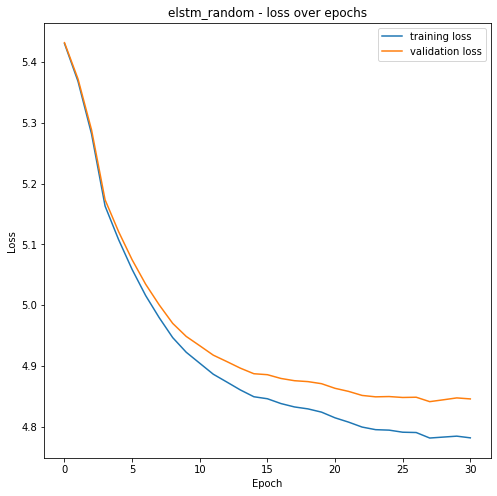

In [27]:
# LSTM on the random embeddings (that are not freezed - trained)
elstm_random = EmbeddLSTM(size=datasets["gen_train"].size(), hidden_size=200,wv=torch.zeros_like(torch.tensor(w2v.wv.vectors)), freeze_wv=False).to(device)
elstm_random_learner = train(elstm_random, datasets["gen_train"], datasets["gen_val"], train_loader, val_loader, "elstm_random", device=device, init_w=lambda n: "weight" in n)

In [ ]:
# LSTM on the random embeddings (that are not freezed - trained) with added intensity
elstm_random_intens = EmbeddLSTM(size=datasets["gen_train"].size(), hidden_size=200,wv=torch.zeros_like(torch.tensor(w2v.wv.vectors)), freeze_wv=False, add_intens=True).to(device)
elstm_random_intens_learner = train(elstm_random_intens, datasets["gen_train"], datasets["gen_val"], train_loader, val_loader, "elstm_random_intens", device=device, init_w=lambda n: "weight" in n)

Epoch:   4%|▍         | 19/500 [1:15:36<32:23:32, 242.44s/it, Train loss=4.78, Val loss=4.83]

In [ ]:
# LSTM on the Spec2Vec embeddings (that are freezed - not trained) with added intensity and large initial forget gate bias
elstm_intens_fg = EmbeddLSTM(size=datasets["gen_train"].size(), hidden_size=200,wv=torch.tensor(w2v.wv.vectors), freeze_wv=True, add_intens=True).to(device)

# init large forget gate bias
for name, param in elstm_intens_fg.named_parameters():
    if "bias" in name and "lstm" in name:
        bias = param
        n = bias.size(0)
        start, end = n//4, n//2
        bias.data[start:end].fill_(1.)

elstm_intens_fg_learner = train(elstm_intens_fg, datasets["gen_train"], datasets["gen_val"], train_loader, val_loader, "elstm_intens_fg", device=device, init_b=lambda x: False)

### Training results
Here we present the development of the loss until the training was early stopped. Notice the y axis numbers!

In [ ]:
# learners = [plstm_learner, plstm_intens_learner, elstm_learner, elstm_intens_learner, 
#             elstm_random_learner, elstm_random_intens_learner, elstm_unfreeze_learner,
#            elstm_unfreeze_intens_learner, elstm_intens_fg_learner]

In [ ]:
# for le in learners:
#     min_val = min(le.val_losses)
#     print(f"Model {le.model_name} has val loss {min_val:.3}")

## Observation:

TODO

Models with embedding layer tends to achieve better val losses. Most notably LSMT on top on freezed Spec2vec embeddings was the best. Still, the difference between embeddings by spec2vec and random ones is almost neglible. 

--> Although embedding layer helps, spec2vec does not improve the model drastically. It makes sense since it has not seen any other data then what we are using for the nonlinear (LSTM/Transformers,...) model. Naturally, this nonlinear model is able to learn similar things as the linear one (Word2vec) does. Even though the optimization criterion is slightly different.

### Forget gate biases:

In [ ]:
for init, l in zip(["normal", "large"],[elstm_intens_learner, elstm_intens_fg_learner]):
    print(f"Model initilized with {init}: ")
    for name, param in l.model.named_parameters():
        if "bias" in name and "lstm" in name:
            bias = param
            n = bias.size(0)
            start, end = n//4, n//2
            print(f"Bias sum: {bias.data[start:end].sum()}")


## Prediction

In [10]:
class PredictorLSTM():
    def __init__(self, model, coder_class, max_mz=None):
        self.model = model
        self.coder = coder_class(model.w2v, max_mz)
        self.add_intens = model.add_intens
        self.onehot = not hasattr(model, "embedding")
              
    @classmethod
    def from_file(cls, file, coder_cls, max_mz=None, device="cpu", w2v=None):
        model = torch.load(file,  map_location=torch.device(device)) 
        model.w2v = w2v
        return cls(model, coder_class=coder_cls, max_mz=max_mz)
    
    
    def __call__(self, X_ds, device="cpu"):

        self.model= self.model.to(device)
        X_ds = X_ds.to(device)
        
        with torch.no_grad():
            # return distribution for next peak 
            return torch.exp(self.model(X_ds, return_sequence=False)[0])
    
    def predict_l_next(self, X_ds, l, filtered=True, device="cpu"):
        """
        receives indices and intens and predicts l next peaks
        if filtered: returns only non-repetitive indices that are not given as input
        """
        raise NotImplementedError
        

    def predict_l_all(self, gen_ds, up_to_k, l, batch_size=64, filtered=True, verbose=False, device="cpu"):
        
        self.model = self.model.to(device)
        gen_ds.onehot = self.onehot
        
        # done in order to extract intensities
        gen_ds.add_intens = True
        
        loader = DataLoader(gen_ds, batch_size=256, shuffle=False, num_workers=8, collate_fn=gen_collate)
  
        X_intens = [] 
        
        l_pred_indices_per_k = np.ones(shape=(up_to_k, len(gen_ds), l)) * (-1)
        y_indices = []
        for b, (X_batch_, y_batch) in enumerate(loader):
                
            y_indices += [y.tolist() for y in y_batch]
            if self.onehot:
                X_intens += [inte.tolist() for inte in X_batch_[:, :, -1]]
                if not self.add_intens:
                    X_batch_ = X_batch_[:, :, :-1]
            else:
                X_intens += [inte.tolist() for inte in X_batch_[:, :, -1]]
                if not self.add_intens:
                    X_batch_ = X_batch_[:, :, 0]
                    
            for j in range(1, up_to_k+1):    
                    
                X_batch = X_batch_[:, :j].clone()
                
                if j > len(y_batch[0]):
                    continue
                
                # drop too short spectra
                # get mask - for each sample in batch either True (long enough) or False (too short) 
                len_mask = y_batch[:, j-1] != -100
                #print(len_mask)
                # no samples in batch left after cutting 
                if len_mask.sum() == 0:
                    continue
                
                X_batch = X_batch[len_mask]
                
                X_batch = X_batch.to(device)

                l_next = self.predict_l_next(X_batch, l, filtered, device=device)
                #print(l_next.shape)
                l_pred_indices_per_k[j-1,b*batch_size: (b+1)*(batch_size)][len_mask] = l_next

            if verbose and b % 1 == 0:
                print(f"Done: {b}/{len(loader)}")
        return l_pred_indices_per_k, y_indices, X_intens 
    


class PredictorDstLSTM(PredictorLSTM):
    def __init__(self, model, coder_class, max_mz=None):
        super().__init__(model, coder_class, max_mz)
        
    def predict_l_next(self, X_ds, l, filtered=True, device="cpu"):
        """
        receives indices and intens and predicts l next peaks
        if filtered: returns only non-repetitive indices that are not given as input
        """
        if not self.add_intens:
#             X_ds = X_ds[:, :, 0].int()
            X_input = X_ds.long()
            if not self.onehot:
                X_ds = X_ds.int()
#                 X_ds = nn.functional.one_hot(X_ds, len(self.vocab))
        else:
            X_input = X_ds[:,:,0].long()
            
        # skipped case for now
        assert not (self.add_intens and self.onehot)
        # print(X_ds.shape)
        
        with torch.no_grad():
            log_prob, _ = self.model(X_ds, return_sequence=False)
        
        if filtered:
            # print(log_prob.shape)
            # print(X_input.shape)
            for i in range(len(log_prob)):
                log_prob[i][X_input[i]] = -float("inf")
            args_batch = torch.argsort(log_prob, dim=-1, descending=True).int().cpu()
         
            return args_batch[:, :l].numpy()
        
        return torch.argsort(logits, dim=-1, descending=True)[:, :l].cpu().numpy()
        
    
class PredictorAutoLSTM(PredictorLSTM):
    def __init__(self, model, coder_class, max_mz=None):
        super().__init__(model, coder_class, max_mz)
        
    def predict_l_next(self, X_ds, l, filtered=True, device="cpu"):
        """
        receives indices and intens and predicts l next peaks
        if filtered: returns only non-repetitive indices that are not given as input
        """
        if not self.add_intens:
#             X_ds = X_ds[:, :, 0].int()
            X_input = X_ds.long()
            if not self.onehot:
                X_ds = X_ds.int()
#                 X_ds = nn.functional.one_hot(X_ds, len(self.vocab))
        else:
            X_input = X_ds[:,:,0].long()
            last_intens = X_ds[:, -1, 1]
        # skipped case for now
        assert not (self.add_intens and self.onehot)
        assert not self.onehot
        
        predicted = torch.ones((len(X_ds), l), dtype=int) * (-1)
        state = None
        auto_X = X_ds
        for j in range(l):
            with torch.no_grad():
                log_prob, state = self.model(auto_X, return_sequence=False, init_state=state)
                
            if filtered:
                for i in range(len(log_prob)):
                    log_prob[i][X_input[i]] = -float("inf")
                    log_prob[i][predicted[i][:j]] = -float("inf")
                    
            
            y_pred = torch.argmax(log_prob, axis=-1)
            
            predicted[:,j] = y_pred
            
            if self.add_intens:
                last_intens = last_intens**.9
                auto_X = torch.cat((y_pred, last_intens), dim=0).reshape(-1,1,2)
            else:
                auto_X = y_pred.reshape(-1,1)
                    
        return predicted.cpu().numpy()
        

    

## Visualisation

In [11]:
from visual_utils import plot_spectrum_predictions


predictor = PredictorDstLSTM.from_file(f"models/{kind}/plstm", TextMzCoder, max_mz=None, w2v=w2v)
predictor.model.cpu()
i = 789
k = 3

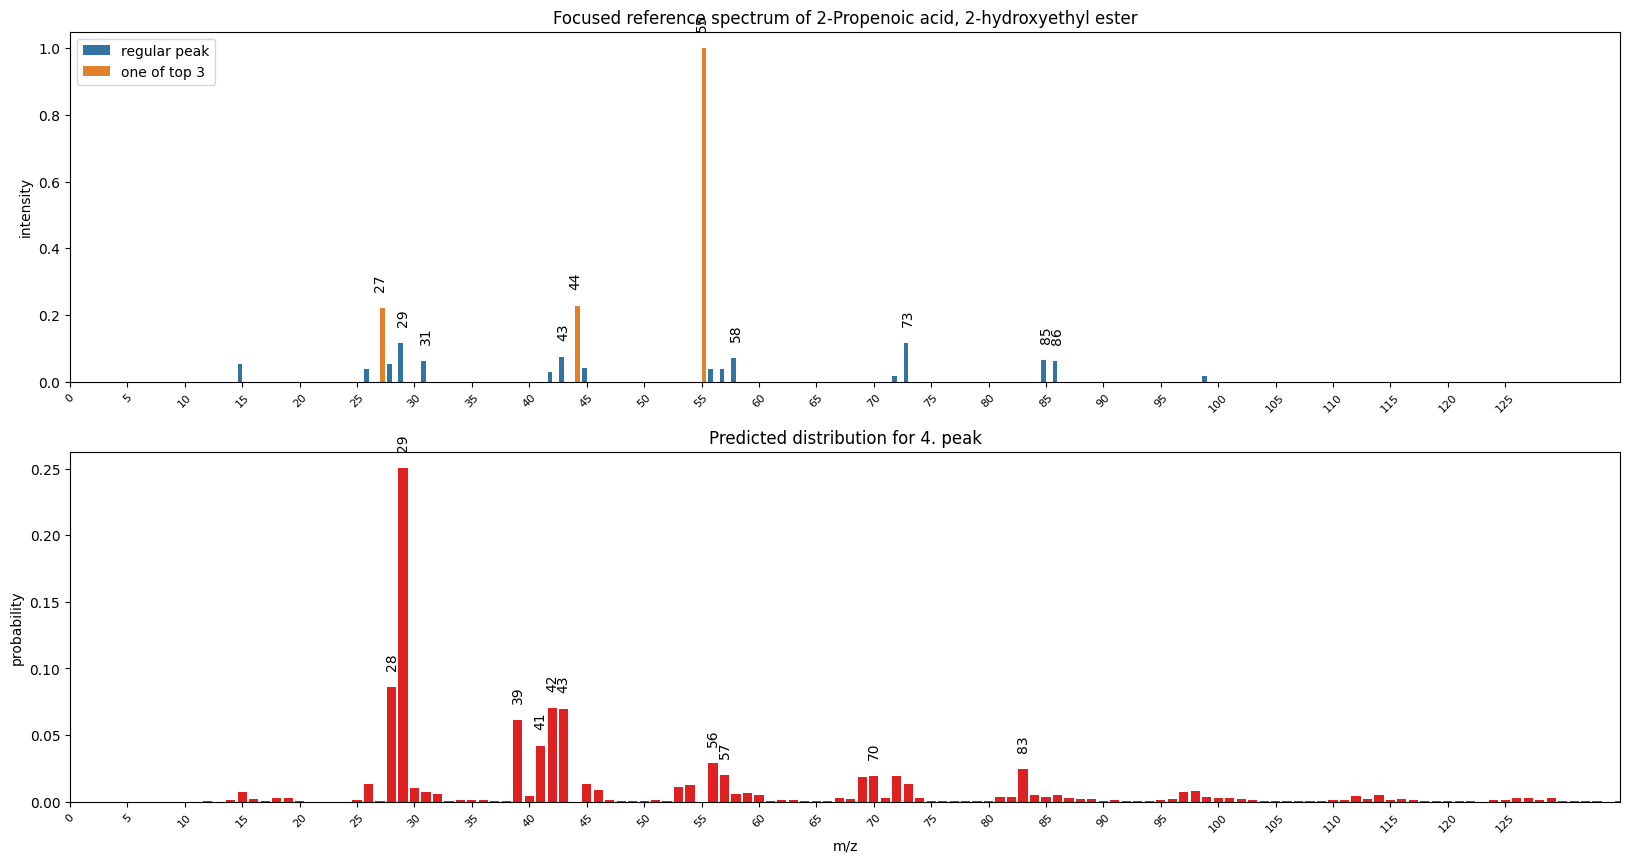

In [12]:
plot_ds = TopKDS(documents_val, vocab, k, onehot=predictor.onehot, add_intensity=predictor.add_intens)
# plot_ds[i][0].reshape(1, *plot_ds[i][0].shape).shape
prob = predictor(plot_ds[i][0].reshape(1, *plot_ds[i][0].shape))[0,:].cpu().numpy()
plot_spectrum_predictions(plot_ds.ref_docs[i], k, prob, predictor.coder, plot_full=False)


## Model Selection
done on the val set

In [13]:
import os
from metrics import metrics_klj, metrics_intlj
predictors = { 
              "plstm_dst": PredictorDstLSTM.from_file(f"models/{kind}/plstm", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                # "plstm_intens_dst": PredictorDstLSTM.from_file(f"models/{kind}/plstm_intens", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_dst": PredictorDstLSTM.from_file(f"models/{kind}/elstm", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_intens_dst": PredictorDstLSTM.from_file(f"models/{kind}/elstm_intens", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_intens_fg_dst": PredictorDstLSTM.from_file(f"models/{kind}/elstm_intens_fg", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_random_dst": PredictorDstLSTM.from_file(f"models/{kind}/elstm_random", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_random_intens_dst": PredictorDstLSTM.from_file(f"models/{kind}/elstm_random_intens", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_unfreeze_dst": PredictorDstLSTM.from_file(f"models/{kind}/elstm_unfreeze", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_unfreeze_intens_dst": PredictorDstLSTM.from_file(f"models/{kind}/elstm_unfreeze_intens", TextMzCoder, max_mz=None, device=device, w2v=w2v),      
                #
                "elstm_auto": PredictorAutoLSTM.from_file(f"models/{kind}/elstm", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_intens_auto": PredictorAutoLSTM.from_file(f"models/{kind}/elstm_intens", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_intens_fg_auto": PredictorAutoLSTM.from_file(f"models/{kind}/elstm_intens_fg", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_random_auto": PredictorAutoLSTM.from_file(f"models/{kind}/elstm_random", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_random_intens_auto": PredictorAutoLSTM.from_file(f"models/{kind}/elstm_random_intens", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_unfreeze_auto": PredictorAutoLSTM.from_file(f"models/{kind}/elstm_unfreeze", TextMzCoder, max_mz=None, device=device, w2v=w2v),
                "elstm_unfreeze_intens_auto": PredictorAutoLSTM.from_file(f"models/{kind}/elstm_unfreeze_intens", TextMzCoder, max_mz=None, device=device, w2v=w2v),      
 }

P_FOLDER = f"predictions/{kind}"
up_to_k = 30
l = 20

In [14]:
from model_evaluation import calc_predictions, load_predictions, model_selection
from visual_utils import plot_scores

In [15]:
%%time
calc_predictions(up_to_k, l, predictors, datasets, "gen_val", P_FOLDER, batch_size=256, device=device, verbose=False)

plstm_dst


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


elstm_dst
elstm_intens_dst
elstm_intens_fg_dst
elstm_random_dst
elstm_random_intens_dst
elstm_unfreeze_dst
elstm_unfreeze_intens_dst
elstm_auto
elstm_intens_auto
elstm_intens_fg_auto
elstm_random_auto
elstm_random_intens_auto
elstm_unfreeze_auto
elstm_unfreeze_intens_auto
CPU times: user 1h 44min 7s, sys: 3min 23s, total: 1h 47min 31s
Wall time: 1h 49min 25s


In [16]:
best_p_name, scores = model_selection(P_FOLDER, d_name, predictors=predictors, up_to_k=20, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None)
plot_scores(scores, metrics="mpi")

NameError: name 'd_name' is not defined

In [ ]:
best_p_name

## Visualisation of the best predictor

In [ ]:
prob = predictor(plot_ds[i][0].reshape(1, *plot_ds[i][0].shape))[0,:].cpu().numpy()
plot_spectrum_predictions(plot_ds.ref_docs[i], k, prob, predictor.coder, plot_full=False)

## Detailed evaluation of the best predictor 
done on the test set

In [21]:
%%time
up_to_k = 50
l = 20
calc_predictions(up_to_k, l, {best_p_name: predictors[best_p_name]}, "gen_test", P_FOLDER)

elstm_intens_fg_dst


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


CPU times: user 32.1 s, sys: 1.36 s, total: 33.4 s
Wall time: 52.4 s


In [22]:
l_pred_indices_per_k_best, y_indices, X_intens = load_predictions(best_p_name, "gen_test", P_FOLDER)
l_pred_indices_per_k_base, y_indices_base, X_intens_base = load_predictions("base_1", "spec_test", P_FOLDER)

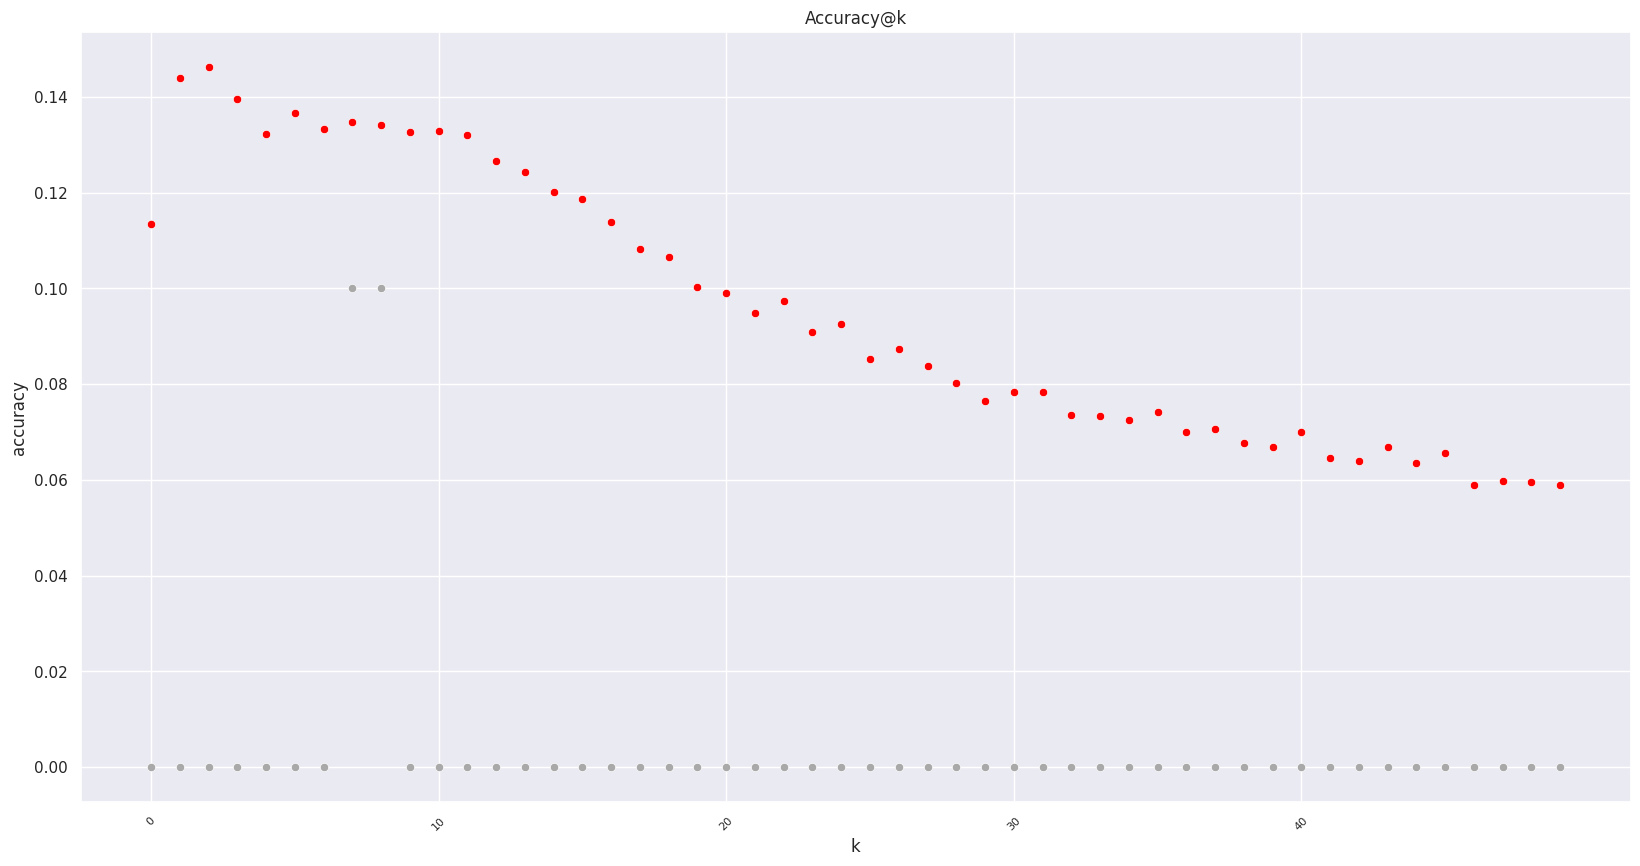

In [23]:
from metrics import accuracy_at_k
from visual_utils import plot_stats

def get_to_len(xs, len_):
    return [xs[i] if i<len(xs) else 0 for i in range(len_)]

accs_at_k = accuracy_at_k(l_pred_indices_per_k_best, y_indices, up_to_k=None)
accs_at_k_base = get_to_len(accuracy_at_k(l_pred_indices_per_k_base, y_indices_base, up_to_k=None), len(accs_at_k))



plot_stats(accs_at_k, baseline1D=accs_at_k_base, title="Accuracy@k", color="red", ylabel='accuracy', xlabel='k')

In [24]:
from metrics import accuracy_at_int

accs_at_int = accuracy_at_int(l_pred_indices_per_k_best, y_indices, X_intens)
accs_at_int_base = get_to_len(accuracy_at_int(l_pred_indices_per_k_base, y_indices_base, X_intens_base), len(accs_at_int))

/mnt/storage-brno6/home/xstary1/raims/metrics.py:154: RuntimeWarning: invalid value encountered in true_divide
  return corr_at_int / tot_at_int


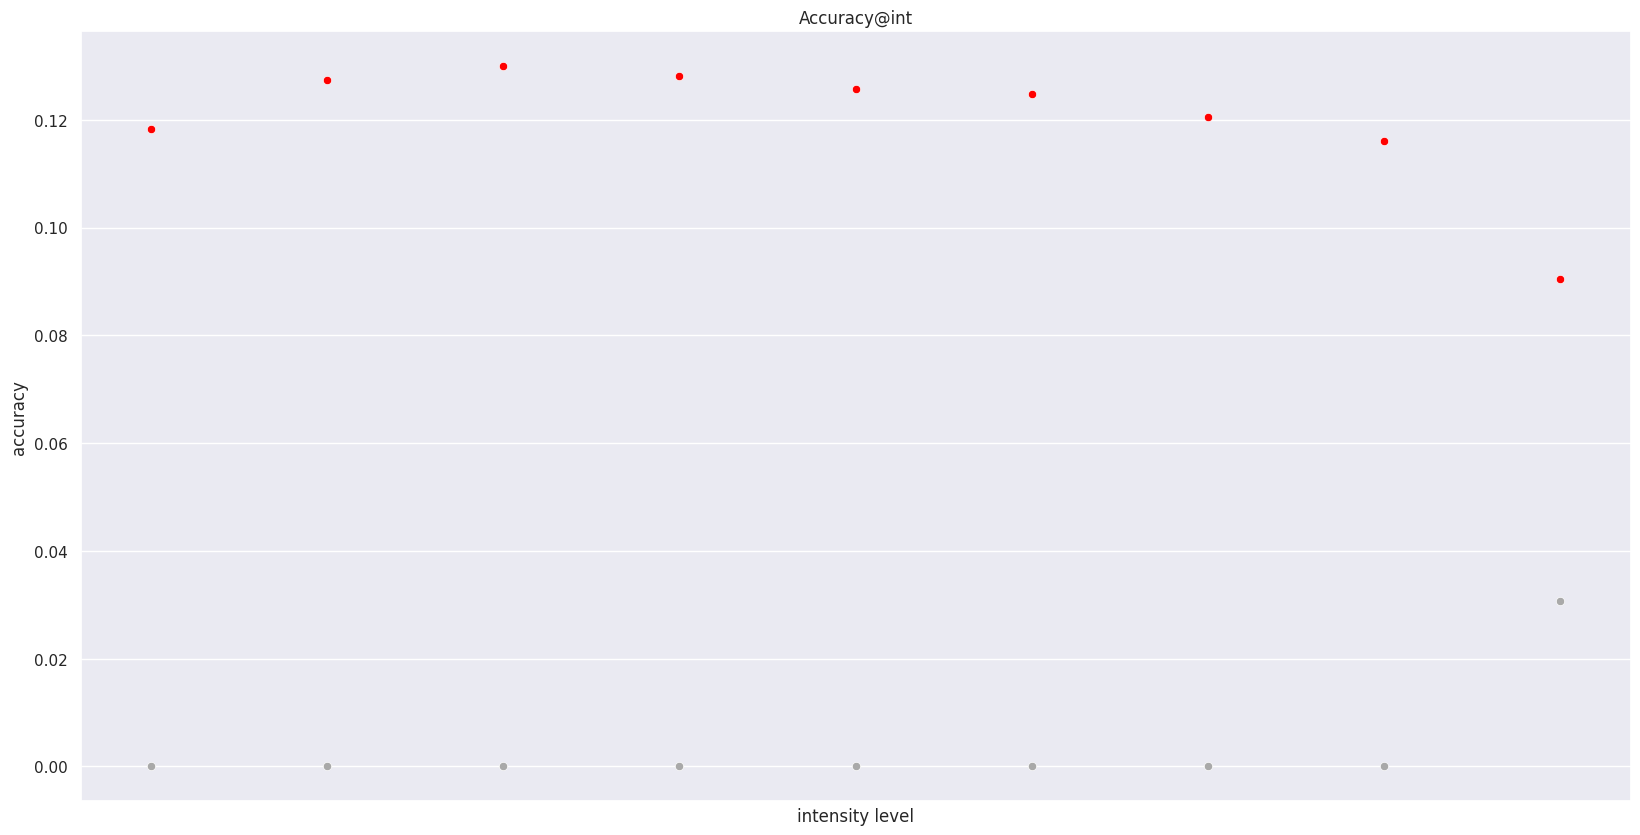

In [25]:
plot_stats(accs_at_int, baseline1D=accs_at_int_base, title="Accuracy@int", color="red", decreasing=True,  ylabel='accuracy', xlabel='intensity level', x_factor=.01)

In [79]:
from metrics import calc_mean_lj_metrics

In [26]:
mean_prec, mean_jac, mean_prec_int, mean_jac_int = calc_mean_lj_metrics(l_pred_indices_per_k_best, y_indices, \
                                                                        X_intens, up_to_k=up_to_k, l=l, j=j)

mean_prec_base, mean_jac_base, mean_prec_int_base, mean_jac_int_base = calc_mean_lj_metrics(l_pred_indices_per_k_base, \
                                                                                            y_indices_base, X_intens_base, \
                                                                                            up_to_k=up_to_k, l=l, j=j)

mean_prec_base = get_to_len(mean_prec_base, len(mean_prec))
mean_jac_base = get_to_len(mean_jac_base, len(mean_jac))

Possible k up to 50, predict up to 4 peaks
Selected up to k=50, l=4, j=6
Possible k up to 10, predict up to 20 peaks
Selected up to k=10, l=4, j=6


/mnt/storage-brno6/home/xstary1/raims/helpers.py:15: RuntimeWarning: Mean of empty slice.
  mean_ = row[~np.isnan(row)].mean()
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


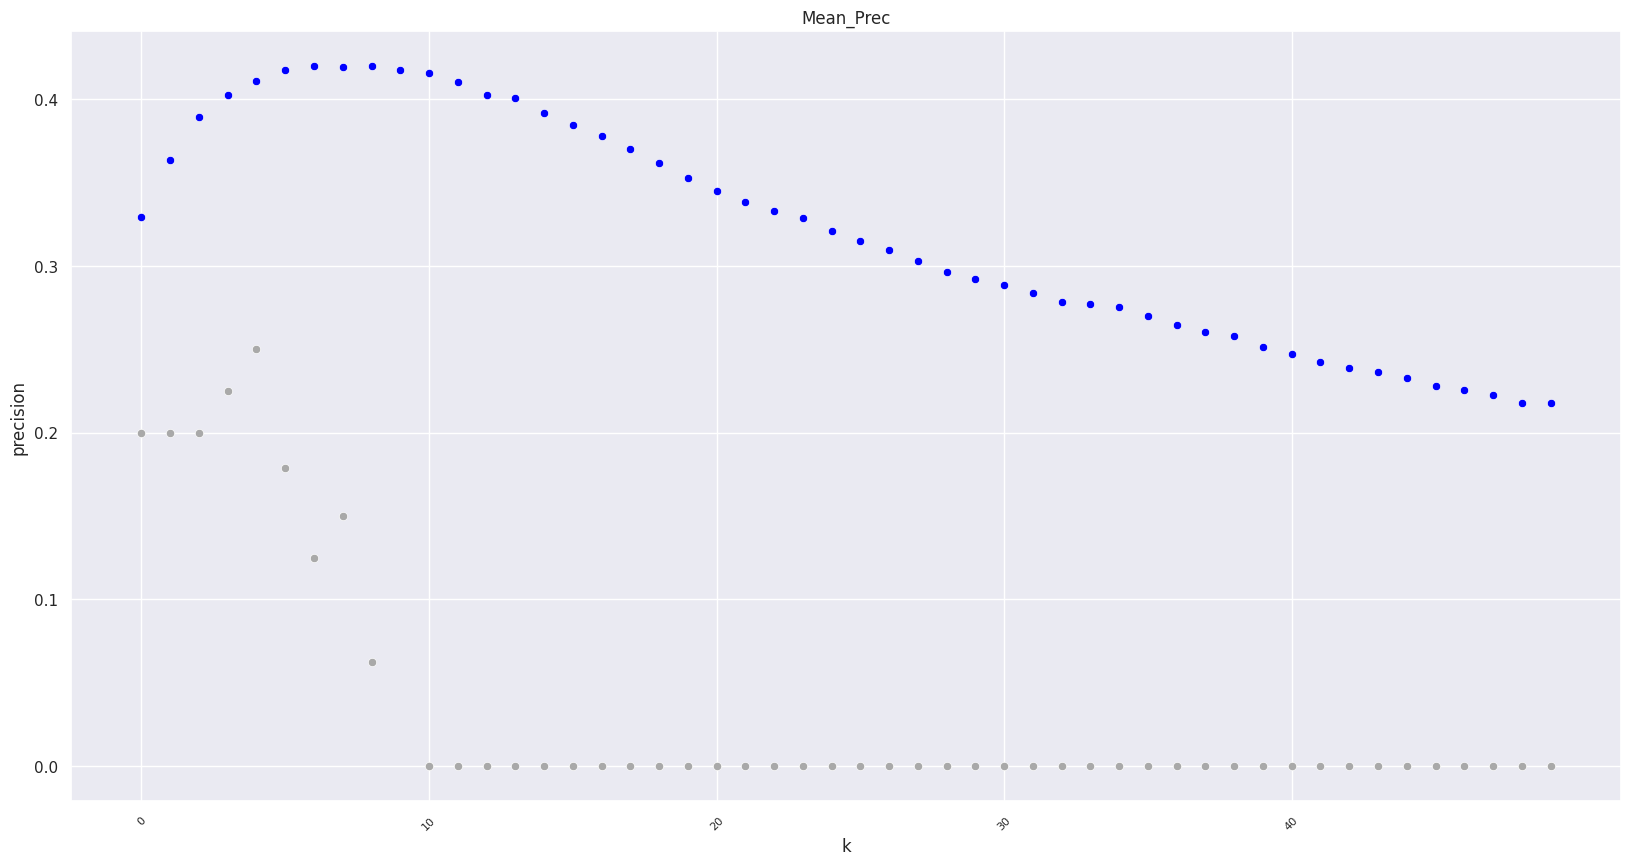

In [27]:
plot_stats(mean_prec, baseline1D=mean_prec_base, title="Mean_Prec", color="blue", ylabel='precision', xlabel='k')

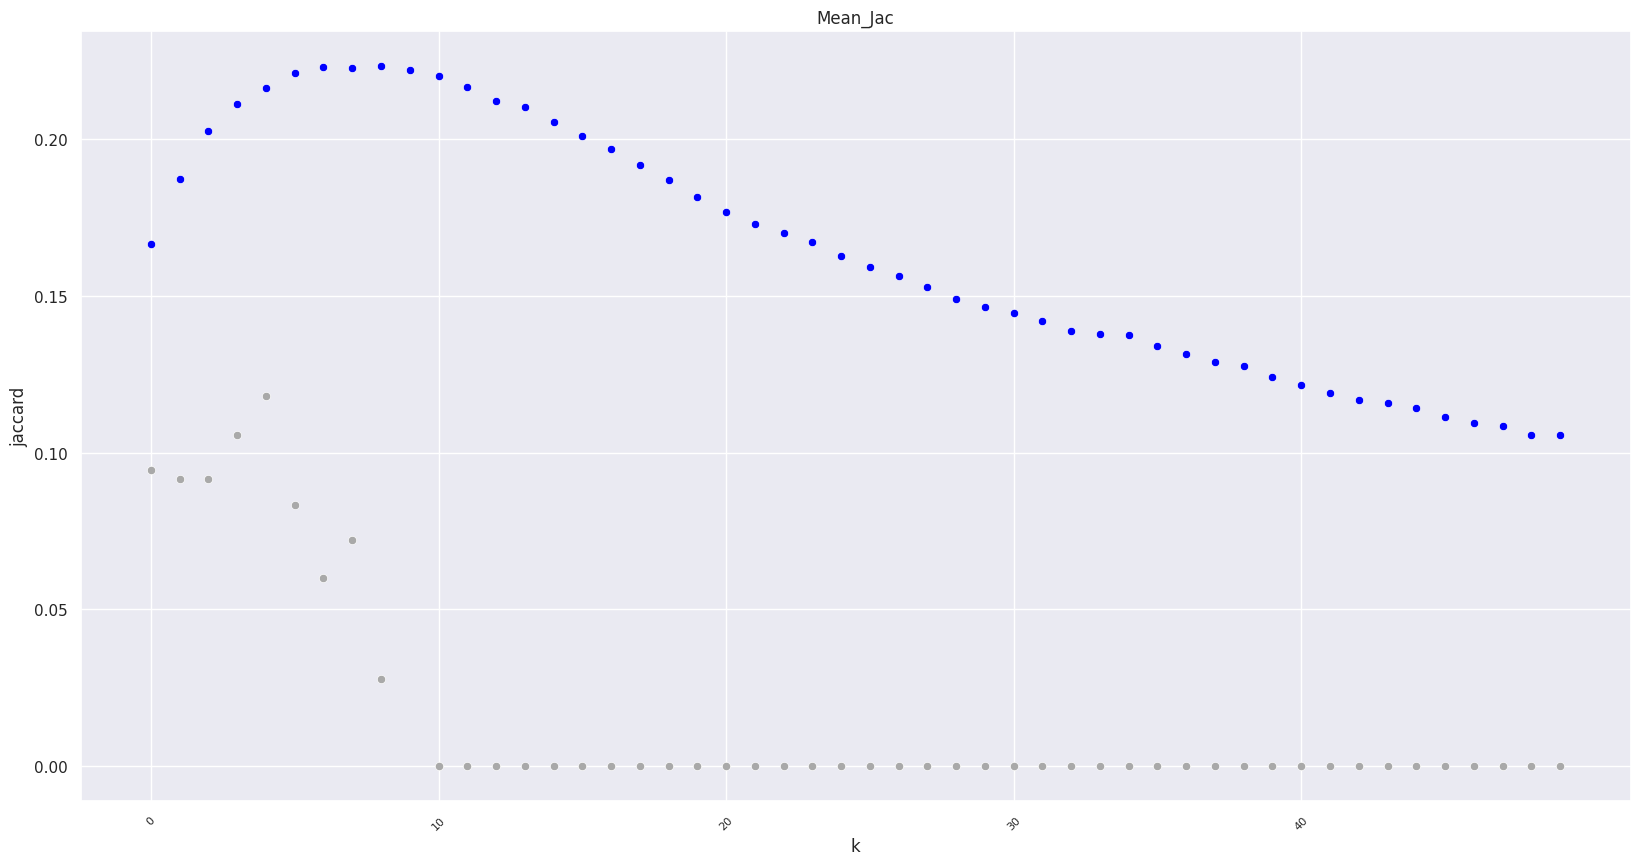

In [28]:
plot_stats(mean_jac, baseline1D=mean_jac_base, title="Mean_Jac", color="blue", ylabel='jaccard', xlabel='k')

# End

In [ ]:
assert False